Weather CSV: D:\git20\geo-toolbox\data_out\weekly_weather_soy_US_BR_OPENMETEO.csv
Prices  CSV: D:\git20\geo-toolbox\data_out\weekly_prices_BG_ADM_SOY.csv


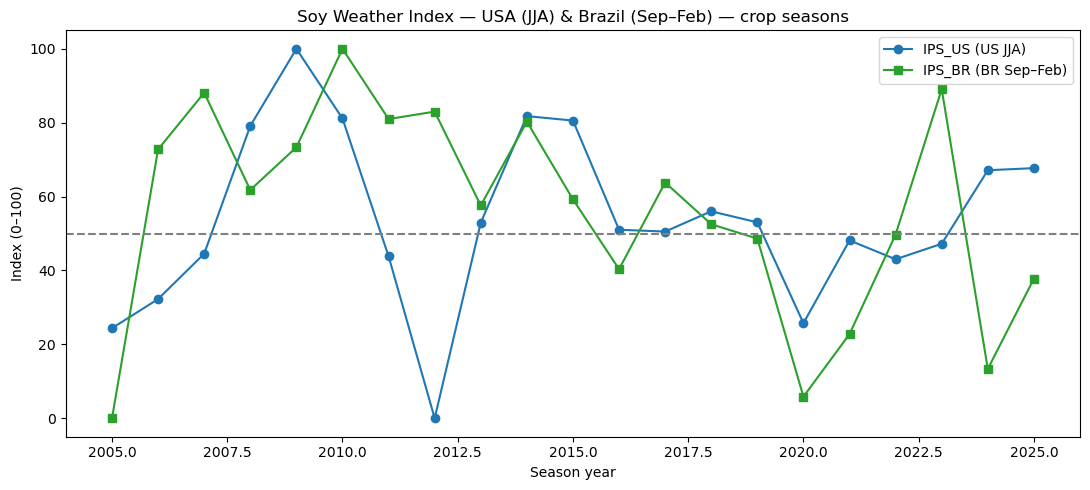

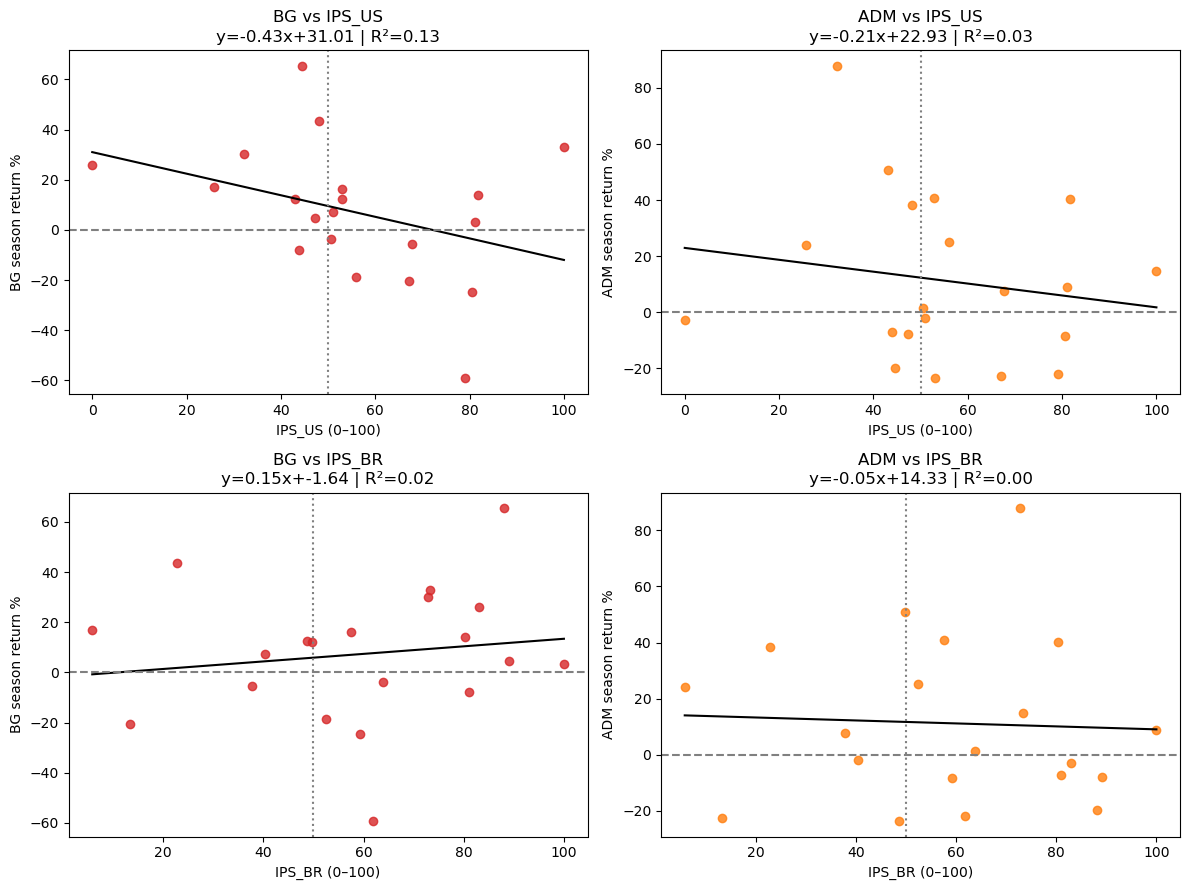

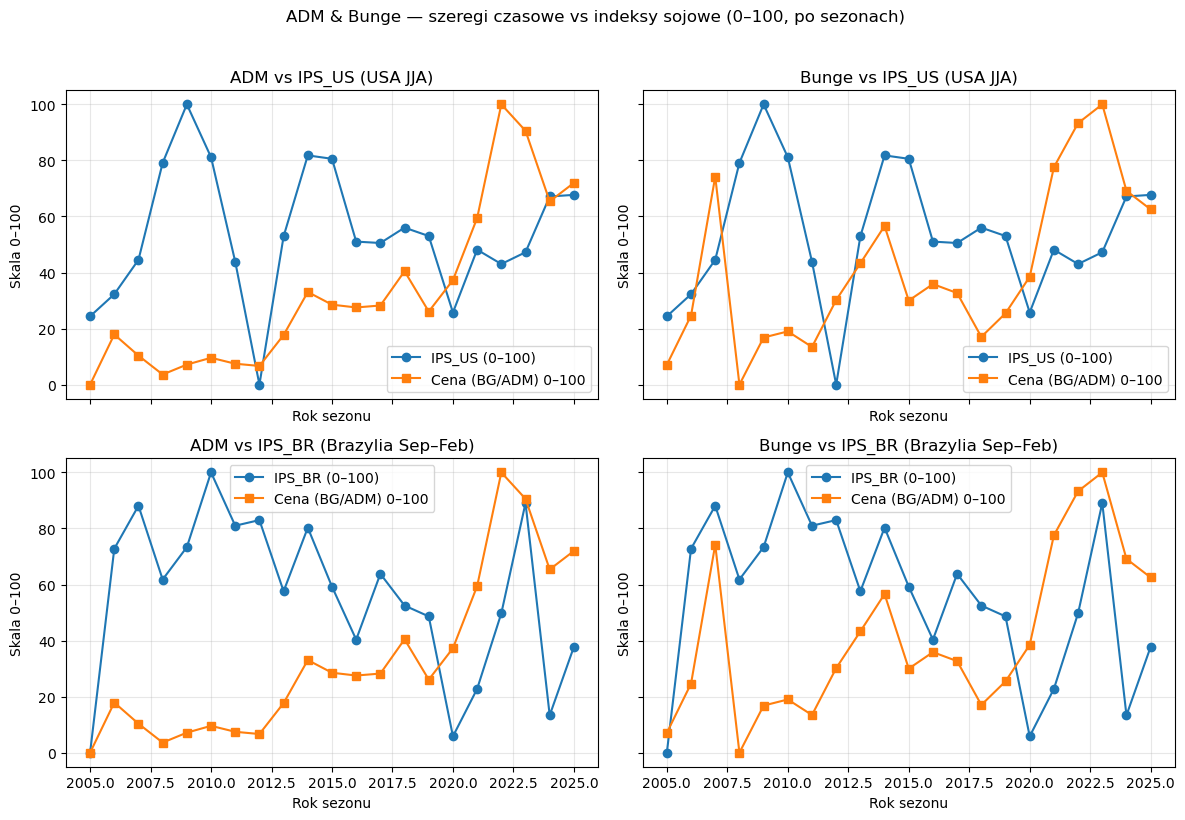

In [10]:
# === Seasonal soy index (0–100, parametric by crop season) + BG/ADM/SOY,
#     seasonal plots, scatter-grid & time-series overlays ===

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ---------- Inputs ----------
DATA_OUT = Path("data_out")
WEATHER_CANDIDATES = [
    DATA_OUT / "weekly_weather_soy_US_BR.csv",
    DATA_OUT / "weekly_weather_soy_US_BR_POWER.csv",
    DATA_OUT / "weekly_weather_soy_US_BR_OPENMETEO.csv",
    DATA_OUT / "weekly_weather_soy_US_BR_IEM.csv",
]
PRICES_CANDIDATES = [
    DATA_OUT / "weekly_prices_BG_ADM_SOY.csv",  # with soy (optional)
    DATA_OUT / "weekly_prices_BG_ADM.csv",      # only BG & ADM
]

def _first_existing(paths):
    for p in paths:
        if Path(p).exists():
            return Path(p)
    raise FileNotFoundError("No matching CSV found. Looked for:\n" + "\n".join(map(str, paths)))

WEATHER_CSV = _first_existing(WEATHER_CANDIDATES)
PRICES_CSV  = _first_existing(PRICES_CANDIDATES)
print("Weather CSV:", WEATHER_CSV.resolve())
print("Prices  CSV:", PRICES_CSV.resolve())

# ---------- Load ----------
w = pd.read_csv(WEATHER_CSV, parse_dates=[0])
w = w.rename(columns={w.columns[0]: "week_end_sun"}).set_index("week_end_sun").sort_index()
for c in ["T_US", "P_US", "T_BR", "P_BR"]:
    if c not in w.columns:
        raise KeyError(f"Missing weather column: {c}. Found: {list(w.columns)}")

p = pd.read_csv(PRICES_CSV, parse_dates=[0])
p = p.rename(columns={p.columns[0]: "week_end_sun"}).set_index("week_end_sun").sort_index()
for c in ["BG_IDX", "ADM_IDX"]:
    if c not in p.columns:
        raise KeyError(f"Missing price column: {c}. Found: {list(p.columns)}")
HAS_SOY = "SOY_IDX" in p.columns

# ---------- Helpers ----------
def season_year_us(ts: pd.Timestamp):
    # USA soybean season: JJA (June–Aug), assigned to year Y
    return ts.year if ts.month in (6,7,8) else np.nan

def season_year_br(ts: pd.Timestamp):
    # Brazil soybean season: Sep–Feb (Sep–Dec Y, Jan–Feb Y+1), assigned to Y+1
    if ts.month >= 9:   # Sep–Dec → season ends next year
        return ts.year + 1
    if ts.month <= 2:   # Jan–Feb → season ending this year
        return ts.year
    return np.nan

def zscore(s: pd.Series) -> pd.Series:
    s = pd.to_numeric(s, errors="coerce")
    mu, sd = s.mean(), s.std(ddof=0)
    return (s - mu)/sd if sd and not np.isnan(sd) else pd.Series(0.0, index=s.index)

def scale_0_100(s: pd.Series) -> pd.Series:
    lo, hi = s.min(), s.max()
    return 100*(s-lo)/(hi-lo) if np.isfinite(lo) and np.isfinite(hi) and hi!=lo else pd.Series(50.0, index=s.index)

# ---------- Compute seasonal IPS ----------
def compute_parametric_seasonal_ips(wdf: pd.DataFrame) -> pd.DataFrame:
    idx = wdf.index
    sy_us = pd.Series([season_year_us(t) for t in idx], index=idx, name="SY_US").dropna()
    sy_br = pd.Series([season_year_br(t) for t in idx], index=idx, name="SY_BR").dropna()

    # USA season = June–Aug
    us_weeks = wdf.loc[wdf.index.month.isin([6,7,8]), ["T_US","P_US"]].copy()
    us_weeks["SY"] = sy_us
    us_season = us_weeks.dropna(subset=["SY"]).groupby("SY").agg(
        T_mean_US=("T_US","mean"),
        P_sum_US=("P_US","sum"),
    )

    # Brazil season = Sep–Feb
    br_mask = wdf.index.month.isin([9,10,11,12,1,2])
    br_weeks = wdf.loc[br_mask, ["T_BR","P_BR"]].copy()
    br_weeks["SY"] = sy_br
    br_season = br_weeks.dropna(subset=["SY"]).groupby("SY").agg(
        T_mean_BR=("T_BR","mean"),
        P_sum_BR=("P_BR","sum"),
    )

    out = pd.concat([us_season, br_season], axis=1)
    if "P_sum_US" in out: out["IPS_US_RAW"] = 0.6*zscore(out["P_sum_US"]) - 0.4*zscore(out["T_mean_US"])
    if "P_sum_BR" in out: out["IPS_BR_RAW"] = 0.6*zscore(out["P_sum_BR"]) - 0.4*zscore(out["T_mean_BR"])
    out["IPS_US"] = scale_0_100(out["IPS_US_RAW"])
    out["IPS_BR"] = scale_0_100(out["IPS_BR_RAW"])
    out.index.name = "season_year"
    return out[["IPS_US","IPS_BR"]]

ips_seasonal = compute_parametric_seasonal_ips(w)

# ---------- Prices at season end ----------
def season_end_price(series: pd.Series, region: str) -> pd.Series:
    s = series.dropna()
    out = {}
    years = range(s.index.min().year, s.index.max().year+1)
    if region=="US":
        # last price in JJA (note: mask includes May per original code comment; adjust if needed)
        for y in years:
            mask = (s.index.year==y) & (s.index.month.isin([5,6,7,8]))
            if mask.any(): out[float(y)] = s[mask].iloc[-1]
    elif region=="BR":
        # last price in Jan–Feb of Y (else fallback to Sep–Dec of Y-1)
        for y in years:
            mask = (s.index.year==y) & (s.index.month.isin([1,2,12]))
            if mask.any():
                out[float(y)] = s[mask].iloc[-1]
            else:
                mask_prev = (s.index.year==(y-1)) & (s.index.month.isin([9,10,11,12]))
                if mask_prev.any(): out[float(y)] = s[mask_prev].iloc[-1]
    return pd.Series(out).sort_index()

px_season = pd.DataFrame(index=ips_seasonal.index)
px_season["BG_END"]  = season_end_price(p["BG_IDX"], "BR").reindex(px_season.index)
px_season["ADM_END"] = season_end_price(p["ADM_IDX"], "US").reindex(px_season.index)
if HAS_SOY:
    px_season["SOY_END_BR"] = season_end_price(p["SOY_IDX"], "BR").reindex(px_season.index)
    px_season["SOY_END_US"] = season_end_price(p["SOY_IDX"], "US").reindex(px_season.index)

px_season["RET_BG_%"]  = 100*px_season["BG_END"].pct_change()
px_season["RET_ADM_%"] = 100*px_season["ADM_END"].pct_change()
if HAS_SOY:
    px_season["RET_SOY_BR_%"] = 100*px_season["SOY_END_BR"].pct_change()
    px_season["RET_SOY_US_%"] = 100*px_season["SOY_END_US"].pct_change()

# ---------- Plots: Seasonal IPS ----------
plt.figure(figsize=(11,5))
plt.plot(ips_seasonal.index, ips_seasonal["IPS_US"], marker="o", label="IPS_US (US JJA)", color="tab:blue")
plt.plot(ips_seasonal.index, ips_seasonal["IPS_BR"], marker="s", label="IPS_BR (BR Sep–Feb)", color="tab:green")
plt.axhline(50, ls="--", color="gray")
plt.title("Soy Weather Index — USA (JJA) & Brazil (Sep–Feb) — crop seasons")
plt.xlabel("Season year"); plt.ylabel("Index (0–100)"); plt.legend(); plt.tight_layout(); plt.show()

# ---------- Plots: Scatter grid (BG & ADM vs IPS_US/BR) ----------
def _scatter(ax,x,y,title,xlab,ylab,color):
    df=pd.concat([x,y],axis=1).dropna()
    if len(df)<3:
        ax.set_title(f"{title}\n[no data]")
        ax.set_xlabel(xlab); ax.set_ylabel(ylab)
        ax.axhline(0,ls="--",color="gray"); ax.axvline(50,ls=":",color="gray")
        return
    X,Y=df.iloc[:,0].values,df.iloc[:,1].values
    ax.scatter(X,Y,color=color,alpha=0.8)
    a,b=np.polyfit(X,Y,1)
    xx=np.linspace(X.min(),X.max(),100)
    ax.plot(xx,a*xx+b,color="black")
    r2=1-np.sum((Y-(a*X+b))**2)/np.sum((Y-Y.mean())**2)
    ax.set_title(f"{title}\ny={a:.2f}x+{b:.2f} | R²={r2:.2f}")
    ax.set_xlabel(xlab); ax.set_ylabel(ylab)
    ax.axhline(0,ls="--",color="gray"); ax.axvline(50,ls=":",color="gray")

fig,axes=plt.subplots(2,2,figsize=(12,9))
_scatter(axes[0,0],ips_seasonal["IPS_US"],px_season["RET_BG_%"],"BG vs IPS_US","IPS_US (0–100)","BG season return %","tab:red")
_scatter(axes[0,1],ips_seasonal["IPS_US"],px_season["RET_ADM_%"],"ADM vs IPS_US","IPS_US (0–100)","ADM season return %","tab:orange")
_scatter(axes[1,0],ips_seasonal["IPS_BR"],px_season["RET_BG_%"],"BG vs IPS_BR","IPS_BR (0–100)","BG season return %","tab:red")
_scatter(axes[1,1],ips_seasonal["IPS_BR"],px_season["RET_ADM_%"],"ADM vs IPS_BR","IPS_BR (0–100)","ADM season return %","tab:orange")
plt.tight_layout(); plt.show()

# ---------- Time series: ADM & BG vs IPS (po sezonach, skala 0–100) ----------
def _norm_0_100(s: pd.Series) -> pd.Series:
    # zachowaj indeks i nan-owanie
    out = scale_0_100(s.dropna())
    return out.reindex(s.index)

def _plot_ts(ax, ips, px, title, ips_label):
    df = pd.concat({
        ips_label: _norm_0_100(ips),
        "Price (0–100)": _norm_0_100(px),
    }, axis=1).dropna()
    if len(df) < 2:
        ax.set_title(f"{title}\n[za mało danych]")
        ax.set_xlabel("Rok sezonu")
        ax.set_ylabel("Skala 0–100 (znormalizowana)")
        ax.grid(True, alpha=0.3)
        return
    ax.plot(df.index, df[ips_label], marker="o", label=ips_label)
    ax.plot(df.index, df["Price (0–100)"], marker="s", label="Cena (BG/ADM) 0–100")
    ax.set_title(title)
    ax.set_xlabel("Rok sezonu")
    ax.set_ylabel("Skala 0–100")
    ax.grid(True, alpha=0.3)
    ax.legend()

fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)

# ADM vs IPS_US (sezon USA JJA)
_ = _plot_ts(
    axes[0,0],
    ips_seasonal["IPS_US"],
    px_season["ADM_END"],
    "ADM vs IPS_US (USA JJA)",
    "IPS_US (0–100)"
)

# BG vs IPS_US
_ = _plot_ts(
    axes[0,1],
    ips_seasonal["IPS_US"],
    px_season["BG_END"],
    "Bunge vs IPS_US (USA JJA)",
    "IPS_US (0–100)"
)

# ADM vs IPS_BR (sezon Brazylia Sep–Feb)
_ = _plot_ts(
    axes[1,0],
    ips_seasonal["IPS_BR"],
    px_season["ADM_END"],
    "ADM vs IPS_BR (Brazylia Sep–Feb)",
    "IPS_BR (0–100)"
)

# BG vs IPS_BR
_ = _plot_ts(
    axes[1,1],
    ips_seasonal["IPS_BR"],
    px_season["BG_END"],
    "Bunge vs IPS_BR (Brazylia Sep–Feb)",
    "IPS_BR (0–100)"
)

plt.suptitle("ADM & Bunge — szeregi czasowe vs indeksy sojowe (0–100, po sezonach)", y=1.02, fontsize=12)
plt.tight_layout()
plt.show()

# ---------- (opcjonalnie) Twinx wariant bez normalizacji ----------
# Jeśli wolisz ceny na surowej skali i indeksy 0–100 na lewej osi,
# odkomentuj blok poniżej, aby narysować 2 dodatkowe wykresy:
#
# def _plot_twinx(ips, px, title, px_label):
#     df = pd.concat({"IPS (0–100)": ips, px_label: px}, axis=1).dropna()
#     if len(df) < 2: return
#     fig, ax1 = plt.subplots(figsize=(8,4))
#     ax1.plot(df.index, df["IPS (0–100)"], marker="o", label="IPS (0–100)", color="tab:blue")
#     ax1.set_xlabel("Rok sezonu"); ax1.set_ylabel("IPS (0–100)", color="tab:blue")
#     ax1.tick_params(axis='y', labelcolor="tab:blue")
#     ax2 = ax1.twinx()
#     ax2.plot(df.index, df[px_label], marker="s", label=px_label, color="tab:orange")
#     ax2.set_ylabel(px_label, color="tab:orange")
#     ax2.tick_params(axis='y', labelcolor="tab:orange")
#     fig.suptitle(title); fig.tight_layout(); plt.show()
#
# _plot_twinx(ips_seasonal["IPS_US"], px_season["ADM_END"], "ADM (poziom) vs IPS_US (0–100)", "ADM poziom")
# _plot_twinx(ips_seasonal["IPS_BR"], px_season["BG_END"],  "BG (poziom)  vs IPS_BR (0–100)",  "BG poziom")

